In [25]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import torchvision
import os

import alex_net
from train import train_model

In [27]:
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}

data_dir = 'tiny-imagenet-200/'

num_workers = {
    'train' : 100,
    'val'   : 0,
    'test'  : 0
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True,num_workers=num_workers[x])
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

tensor([121, 157,  33, 191,  85,   5,   3,  98,  87,  62,  83,  48, 197, 117,
         36, 124, 137,  50, 155,  71])


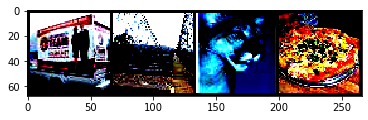

In [28]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

images, labels = next(iter(dataloaders['train']))
print(labels)
grid_img = make_grid(images[:4], nrow=4)
imshow(grid_img)

In [29]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [30]:
net = alex_net.AlexNet()     # Create the network instance.
net.to(device)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU

In [31]:
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr = 0.005, momentum=0.9)

In [33]:
#avg_losses = train_model(net, opt, loss_func, dataloaders, device, epochs=13)
avg_losses = []   # Avg. losses.
print_freq = 100
epochs = 13

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, (inputs, labels) in enumerate(dataloaders['train']):

        net.train()

            # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
        opt.zero_grad()

            # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

            # Backward step.
        loss.backward()

            # Optimization step (update the parameters).
        opt.step()

            # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 5.299
[epoch: 0, i:   199] avg mini-batch loss: 5.298
[epoch: 0, i:   299] avg mini-batch loss: 5.298
[epoch: 0, i:   399] avg mini-batch loss: 5.299
[epoch: 0, i:   499] avg mini-batch loss: 5.299
[epoch: 0, i:   599] avg mini-batch loss: 5.299
[epoch: 0, i:   699] avg mini-batch loss: 5.298
[epoch: 0, i:   799] avg mini-batch loss: 5.297
[epoch: 0, i:   899] avg mini-batch loss: 5.296
[epoch: 0, i:   999] avg mini-batch loss: 5.276
[epoch: 0, i:  1099] avg mini-batch loss: 5.257
[epoch: 0, i:  1199] avg mini-batch loss: 5.248


KeyboardInterrupt: 

In [ ]:
print_freq = 100

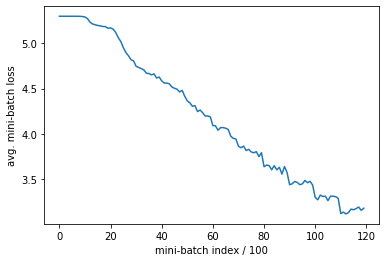

In [39]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [40]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(dataloaders['test']):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 23 %
